![](img/330-banner.png)

# Lecture 8: Hyperparameter Optimization and Optimization Bias

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports, Announcements, and LO

### Imports

In [1]:
import os
import sys

sys.path.append("code/.")

import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *


%matplotlib inline
pd.set_option("display.max_colwidth", 200)

<br><br>

### Announcements

- HW3 was due last night. 
- HW4 will be released by tonight. (It will be due next Tuesday.)
- HW2 grades are released. 
- Apologies that no one showed up to the Zoom OH yesterday. I'll make sure this doesn't happen again.  

### Learning outcomes 

From this lecture, you will be able to 

- explain the need for hyperparameter optimization  
- carry out hyperparameter optimization using `sklearn`'s `GridSearchCV` and `RandomizedSearchCV` 
- explain different hyperparameters of `GridSearchCV`
- explain the importance of selecting a good range for the values. 
- explain optimization bias
- identify and reason when to trust and not trust reported accuracies 

<br><br><br><br>

## Hyperparameter optimization motivation 

### Motivation

- Remember that the fundamental goal of supervised machine learning is to generalize beyond what we see in the training examples. 
- We have been using data splitting and cross-validation to provide a framework to approximate generalization error.  
- With this framework, we can improve the model's generalization performance by tuning model hyperparameters using cross-validation on the training set. 

### Hyperparameters: the problem

- In order to improve the generalization performance, finding the best values for the important hyperparameters of a model is necessary for almost all models and datasets. 
- Picking good hyperparameters is important because if we don't do it, we might end up with an underfit or overfit model. 

### Some ways to pick hyperparameters:
- Manual or expert knowledge or heuristics based optimization 
- Data-driven or automated optimization

#### Manual hyperparameter optimization

- Advantage: we may have some intuition about what might work.
  - E.g. if I'm massively overfitting, try decreasing `max_depth` or `C`.
- Disadvantages
    - it takes a lot of work
    - not reproducible
    - in very complicated cases, our intuition might be worse than a data-driven approach

### Automated hyperparameter optimization 

- Formulate the hyperparamter optimization as a one big search problem. 
- Often we have many hyperparameters of different types: Categorical, integer, and continuous.
- Often, the search space is quite big and systematic search for optimal values is infeasible. 

In homework assignments, we have been carrying out hyperparameter search by exhaustively trying different possible combinations of the hyperparameters of interest. 

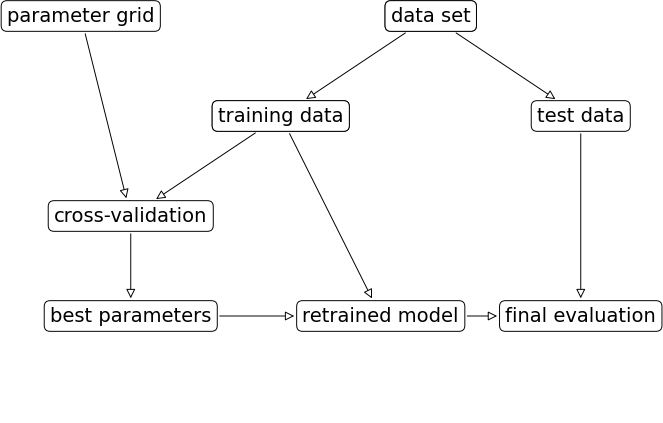

In [2]:
mglearn.plots.plot_grid_search_overview()

Let's look at an example of tuning `max_depth` of the `DecisionTreeClassifier` on the Spotify dataset. 

In [3]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "song_title", "artist"])
y_spotify = spotify_df["target"]
X_spotify.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

In [5]:
best_score = 0

param_grid = {"max_depth": np.arange(1, 20, 2)}

results_dict = {"max_depth": [], "mean_cv_score": []}

for depth in param_grid[
    "max_depth"
]:  # for each combination of parameters, train an SVC
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(dt, X_train, y_train)  # perform cross-validation
    mean_score = np.mean(scores)  # compute mean cross-validation accuracy
    if (
        mean_score > best_score
    ):  # if we got a better score, store the score and parameters
        best_score = mean_score
        best_params = {"max_depth": depth}
    results_dict["max_depth"].append(depth)
    results_dict["mean_cv_score"].append(mean_score)

In [6]:
best_params

{'max_depth': 5}

In [7]:
best_score

0.7173009249466377

Let's try SVM RBF and tuning `C` and `gamma` on the same dataset. 

In [8]:
pipe_svm = make_pipeline(StandardScaler(), SVC())  # We need scaling for SVM RBF
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

Let's try cross-validation with default hyperparameters of SVC. 

In [9]:
scores = cross_validate(pipe_svm, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.029846
score_time     0.010030
test_score     0.738998
train_score    0.814011
dtype: float64

Now let's try exhaustive hyperparameter search using for loops. 

This is what we have been doing for this:

```
for gamma in [0.01, 1, 10, 100]: # for some values of gamma
    for C in [0.01, 1, 10, 100]: # for some values of C
        for fold in folds:
            fit in training portion with the given C
            score on validation portion
        compute average score
        
pick hyperparameter values which yield with best average score
```

In [10]:
best_score = 0

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}

results_dict = {"C": [], "gamma": [], "mean_cv_score": []}

for gamma in param_grid["gamma"]:
    for C in param_grid["C"]:  # for each combination of parameters, train an SVC
        pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=gamma, C=C))
        scores = cross_val_score(pipe_svm, X_train, y_train)  # perform cross-validation
        mean_score = np.mean(scores)  # compute mean cross-validation accuracy
        if (
            mean_score > best_score
        ):  # if we got a better score, store the score and parameters
            best_score = mean_score
            best_parameters = {"C": C, "gamma": gamma}
        results_dict["C"].append(C)
        results_dict["gamma"].append(gamma)
        results_dict["mean_cv_score"].append(mean_score)

In [11]:
best_parameters

{'C': 1, 'gamma': 0.1}

In [12]:
best_score

0.7439609253312309

In [13]:
df = pd.DataFrame(results_dict)

In [14]:
df.sort_values(by="mean_cv_score", ascending=False).head(10)

,C,gamma,mean_cv_score
15,1.0,0.100,0.743961
11,100.0,0.010,0.732792
16,10.0,0.100,0.729091
10,10.0,0.010,0.720391
17,100.0,0.100,0.711715
5,100.0,0.001,0.704284
14,0.1,0.100,0.703034
9,1.0,0.010,0.697473
8,0.1,0.010,0.678851
4,10.0,0.001,0.678244


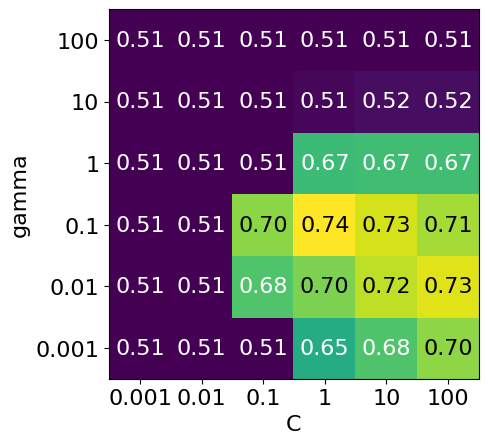

In [15]:
scores = np.array(df.mean_cv_score).reshape(6, 6)

mglearn.tools.heatmap(
    scores,
    xlabel="C",
    xticklabels=param_grid["C"],
    ylabel="gamma",
    yticklabels=param_grid["gamma"],
    cmap="viridis",
)
# plot the mean cross-validation scores

- We have 6 possible values for `C` and 6 possible values for `gamma`. 
- In 5-fold cross-validation, for each combination of parameter values, five accuracies are computed.
- So to evaluate the accuracy of the SVM using 6 values of `C` and 6 values of `gamma` using five-fold cross-validation, we need to train 36 * 5 = 180 models! 

In [16]:
np.prod(list(map(len, param_grid.values())))

36

Once we have optimized hyperparameters, we retrain a model on the full training set with these optimized hyperparameters. 

In [17]:
pipe_svm = make_pipeline(StandardScaler(), SVC(**best_parameters))
pipe_svm.fit(
    X_train, y_train
)  # Retrain a model with optimized hyperparameters on the combined training and validation set

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=0.1))])

And finally evaluate the performance of this model on the test set. 

In [18]:
pipe_svm.score(X_test, y_test)  # Final evaluation on the test data

0.7376237623762376

This process is so common that there are some standard methods in `scikit-learn` where we can carry out all of this in a more compact way. 

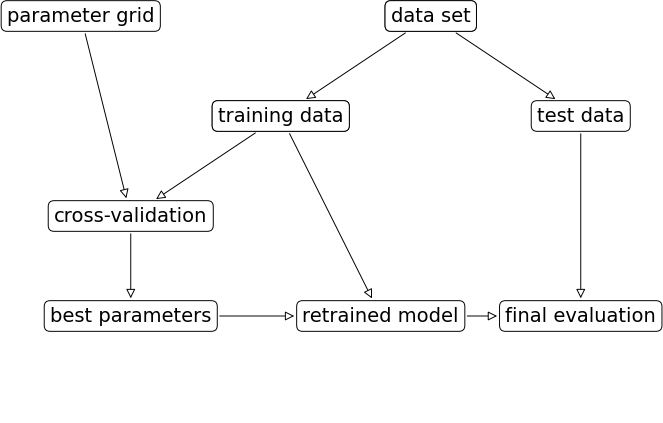

In [19]:
mglearn.plots.plot_grid_search_overview()

In this lecture we are going to talk about two such most commonly used automated optimizations methods from `scikit-learn`. 

- Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Randomized search: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

The "CV" stands for cross-validation; these methods have built-in cross-validation.

<br><br><br><br>

## Exhaustive grid search: [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- For `GridSearchCV` we need
    - an instantiated model or a pipeline
    - a parameter grid: A user specifies a set of values for each hyperparameter. 
    - other optional arguments 

The method considers product of the sets and evaluates each combination one by one.    

In [20]:
from sklearn.model_selection import GridSearchCV

pipe_svm = make_pipeline(StandardScaler(), SVC())

param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_svm, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

In [21]:
from sklearn import set_config

set_config(display="diagram")

The `GridSearchCV` object above behaves like a classifier. We can call `fit`, `predict` or `score` on it. 

In [22]:
grid_search.fit(X_train, y_train) # all the work is done here
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100]},
             return_train_score=True)

Fitting the `GridSearchCV` object 
- Searches for the best hyperparameter values
- You can access the best score and the best hyperparameters using `best_score_` and `best_params_` attributes, respectively. 

In [23]:
grid_search.best_score_

0.7439609253312309

In [24]:
grid_search.best_params_

{'svc__C': 1.0, 'svc__gamma': 0.1}

- It is often helpful to visualize results of all cross-validation experiments. 
- You can access this information using `cv_results_` attribute of a fitted `GridSearchCV` object.  

In [25]:
results = pd.DataFrame(grid_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
mean_fit_time,0.066296,0.064128,0.059034,0.057335,0.054872,0.05148,0.058355,0.056237,0.05534,0.058058,...,0.062906,0.069162,0.070338,0.071929,0.05157,0.069807,0.110082,0.068692,0.076717,0.061162
std_fit_time,0.006657,0.006794,0.005885,0.005523,0.006118,0.007412,0.006662,0.004874,0.003858,0.007704,...,0.006532,0.005437,0.001641,0.008631,0.005295,0.001971,0.009852,0.003563,0.008102,0.015702
mean_score_time,0.018925,0.022579,0.020238,0.020394,0.022572,0.019949,0.02293,0.023417,0.024093,0.021138,...,0.013304,0.020209,0.019604,0.022234,0.01363,0.012289,0.01075,0.022028,0.025075,0.016178
std_score_time,0.002668,0.003075,0.000956,0.000246,0.003729,0.004199,0.003785,0.003897,0.005603,0.002371,...,0.002246,0.000794,0.001518,0.002944,0.002532,0.002715,0.002119,0.008888,0.006929,0.00487
param_svc__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,10,10,10,10,100,100,100,100,100,100
param_svc__gamma,0.001,0.01,0.1,1.0,10,100,0.001,0.01,0.1,1.0,...,0.1,1.0,10,100,0.001,0.01,0.1,1.0,10,100
params,"{'svc__C': 0.001, 'svc__gamma': 0.001}","{'svc__C': 0.001, 'svc__gamma': 0.01}","{'svc__C': 0.001, 'svc__gamma': 0.1}","{'svc__C': 0.001, 'svc__gamma': 1.0}","{'svc__C': 0.001, 'svc__gamma': 10}","{'svc__C': 0.001, 'svc__gamma': 100}","{'svc__C': 0.01, 'svc__gamma': 0.001}","{'svc__C': 0.01, 'svc__gamma': 0.01}","{'svc__C': 0.01, 'svc__gamma': 0.1}","{'svc__C': 0.01, 'svc__gamma': 1.0}",...,"{'svc__C': 10, 'svc__gamma': 0.1}","{'svc__C': 10, 'svc__gamma': 1.0}","{'svc__C': 10, 'svc__gamma': 10}","{'svc__C': 10, 'svc__gamma': 100}","{'svc__C': 100, 'svc__gamma': 0.001}","{'svc__C': 100, 'svc__gamma': 0.01}","{'svc__C': 100, 'svc__gamma': 0.1}","{'svc__C': 100, 'svc__gamma': 1.0}","{'svc__C': 100, 'svc__gamma': 10}","{'svc__C': 100, 'svc__gamma': 100}"
split0_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.702786,0.671827,0.517028,0.504644,0.73065,0.73065,0.705882,0.671827,0.517028,0.504644
split1_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.767802,0.671827,0.510836,0.510836,0.708978,0.758514,0.76161,0.671827,0.510836,0.510836
split2_test_score,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,...,0.693498,0.662539,0.517028,0.50774,0.662539,0.71517,0.671827,0.662539,0.517028,0.50774


In [26]:
results = (
    pd.DataFrame(grid_search.cv_results_).set_index("rank_test_score").sort_index()
)
display(results.T)

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,21,21,21,21,21,21,21,21,21,21
mean_fit_time,0.051213,0.069807,0.062906,0.04916,0.110082,0.05157,0.060647,0.058823,0.056439,0.051582,...,0.05534,0.056237,0.058355,0.05148,0.054872,0.057335,0.059034,0.064128,0.063345,0.07472
std_fit_time,0.011911,0.001971,0.006532,0.006423,0.009852,0.005295,0.003819,0.009956,0.005779,0.006732,...,0.003858,0.004874,0.006662,0.007412,0.006118,0.005523,0.005885,0.006794,0.002926,0.015091
mean_score_time,0.018556,0.012289,0.013304,0.011951,0.01075,0.01363,0.016769,0.017151,0.018264,0.014593,...,0.024093,0.023417,0.02293,0.019949,0.022572,0.020394,0.020238,0.022579,0.01736,0.021388
std_score_time,0.001704,0.002715,0.002246,0.002497,0.002119,0.002532,0.003261,0.006553,0.002416,0.002415,...,0.005603,0.003897,0.003785,0.004199,0.003729,0.000246,0.000956,0.003075,0.003515,0.007943
param_svc__C,1.0,100,10,10,100,100,0.1,1.0,0.1,10,...,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.1,0.1
param_svc__gamma,0.1,0.01,0.1,0.01,0.1,0.001,0.1,0.01,0.01,0.001,...,0.1,0.01,0.001,100,10,1.0,0.1,0.01,10,100
params,"{'svc__C': 1.0, 'svc__gamma': 0.1}","{'svc__C': 100, 'svc__gamma': 0.01}","{'svc__C': 10, 'svc__gamma': 0.1}","{'svc__C': 10, 'svc__gamma': 0.01}","{'svc__C': 100, 'svc__gamma': 0.1}","{'svc__C': 100, 'svc__gamma': 0.001}","{'svc__C': 0.1, 'svc__gamma': 0.1}","{'svc__C': 1.0, 'svc__gamma': 0.01}","{'svc__C': 0.1, 'svc__gamma': 0.01}","{'svc__C': 10, 'svc__gamma': 0.001}",...,"{'svc__C': 0.01, 'svc__gamma': 0.1}","{'svc__C': 0.01, 'svc__gamma': 0.01}","{'svc__C': 0.01, 'svc__gamma': 0.001}","{'svc__C': 0.001, 'svc__gamma': 100}","{'svc__C': 0.001, 'svc__gamma': 10}","{'svc__C': 0.001, 'svc__gamma': 1.0}","{'svc__C': 0.001, 'svc__gamma': 0.1}","{'svc__C': 0.001, 'svc__gamma': 0.01}","{'svc__C': 0.1, 'svc__gamma': 10}","{'svc__C': 0.1, 'svc__gamma': 100}"
split0_test_score,0.755418,0.73065,0.702786,0.739938,0.705882,0.73065,0.705882,0.702786,0.693498,0.69969,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774
split1_test_score,0.755418,0.758514,0.767802,0.733746,0.76161,0.708978,0.718266,0.705882,0.702786,0.674923,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774
split2_test_score,0.712074,0.71517,0.693498,0.696594,0.671827,0.662539,0.690402,0.659443,0.653251,0.653251,...,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774,0.50774


Let's only look at the most relevant rows. 

In [27]:
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,21,21,21,21,21,21,21,21,21,21
mean_test_score,0.743961,0.732792,0.729091,0.720391,0.711715,0.704284,0.703034,0.697473,0.678851,0.678244,...,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775,0.50775
param_svc__gamma,0.1,0.01,0.1,0.01,0.1,0.001,0.1,0.01,0.01,0.001,...,0.1,0.01,0.001,100,10,1.0,0.1,0.01,10,100
param_svc__C,1.0,100,10,10,100,100,0.1,1.0,0.1,10,...,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.1,0.1
mean_fit_time,0.051213,0.069807,0.062906,0.04916,0.110082,0.05157,0.060647,0.058823,0.056439,0.051582,...,0.05534,0.056237,0.058355,0.05148,0.054872,0.057335,0.059034,0.064128,0.063345,0.07472


- Other than searching for best hyperparameter values, `GridSearchCV` also fits a new model on the whole training set with the parameters that yielded the best results. 
- So we can conveniently call `score` on the test set with a fitted `GridSearchCV` object. 

In [28]:
grid_search.score(X_test, y_test)

0.7376237623762376

Why are `best_score_` and the score above different? 

### `n_jobs=-1`
- Note the `n_jobs=-1` above.
- Hyperparameter optimization can be done _in parallel_ for each of the configurations.
- This is very useful when scaling up to large numbers of machines in the cloud.

### The `__` syntax 

- Above: we have a nesting of transformers.
- We can access the parameters of the "inner" objects by using __ to go "deeper":
- `svc__gamma`: the `gamma` of the `svc` of the pipeline
- `svc__C`: the `C` of the `svc` of the pipeline

In [29]:
from sklearn.model_selection import GridSearchCV

pipe_svm = make_pipeline(StandardScaler(), SVC())

param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_svm, param_grid, cv=5, n_jobs=-1, return_train_score=True
)
# grid_search.fit(X_train, y_train)

### Range of `C`

- Note the exponential range for `C`. This is quite common.
- There is no point trying $C=\{1,2,3\ldots,100\}$ because $C=1,2,3$ are too similar to each other.
- Often we're trying to find an order of magnitude, e.g. $C=\{0.01,0.1,1,10,100\}$. 
- We can also write that as $C=\{10^{-2},10^{-1},10^0,10^1,10^2\}$. 
- Or, in other words, $C$ values to try are $10^n$ for $n=-2,-1,0,1,2$ which is basically what we have above.

<br><br>

### Visualizing the parameter grid as a heatmap 

In [30]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    mglearn.tools.heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svc__gamma"],
        ylabel="C",
        yticklabels=param_grid["svc__C"],
        cmap="viridis",
    );

- Note that the range we pick for the parameters play an important role in hyperparameter optimization. 
- For example, consider the following grid and the corresponding results.  

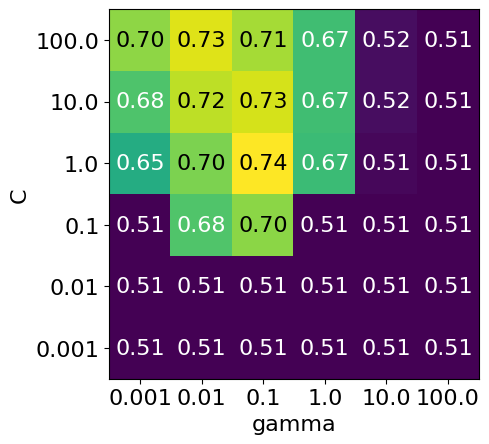

In [31]:
param_grid1 = {
    "svc__gamma": 10.0**np.arange(-3, 3, 1), 
    "svc__C": 10.0**np.arange(-3, 3, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

- Each point in the heat map corresponds to one run of cross-validation, with a particular setting
- Colour encodes cross-validation accuracy. 
    - Lighter colour means high accuracy
    - Darker colour means low accuracy
- SVC is quite sensitive to hyperparameter settings.
- Adjusting hyperparameters can change the accuracy from 0.51 to 0.74! 

### Bad range for hyperparameters 

In [32]:
np.logspace(1, 2, 6)

array([ 10.        ,  15.84893192,  25.11886432,  39.81071706,
        63.09573445, 100.        ])

In [33]:
np.linspace(1, 2, 6)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

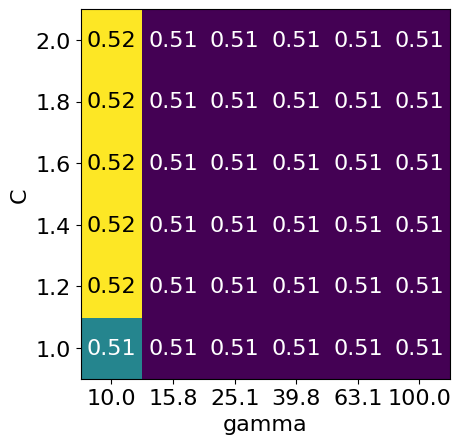

In [34]:
param_grid2 = {"svc__gamma": np.round(np.logspace(1, 2, 6), 1), "svc__C": np.linspace(1, 2, 6)}
display_heatmap(param_grid2, pipe_svm, X_train, y_train)

### Different range for hyperparameters yields better results! 

In [35]:
np.logspace(-3, 2, 6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [36]:
np.linspace(1, 2, 6)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

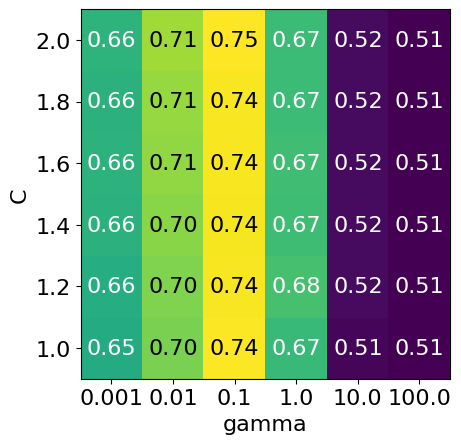

In [37]:
param_grid3 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(1, 2, 6)}

display_heatmap(param_grid3, pipe_svm, X_train, y_train)

It seems like we are getting even better cross-validation results with `C` = 2.0 and `gamma` = 0.1 

How about exploring different values of `C` close to 2.0? 

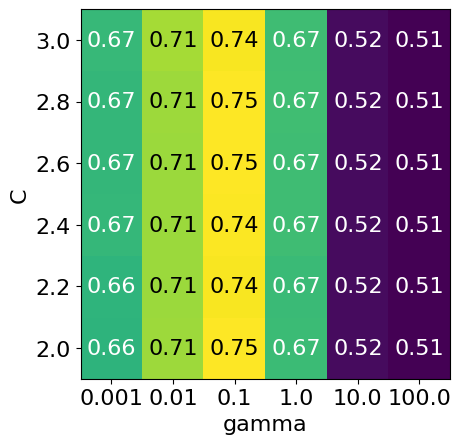

In [38]:
param_grid4 = {"svc__gamma": np.logspace(-3, 2, 6), "svc__C": np.linspace(2, 3, 6)}

display_heatmap(param_grid4, pipe_svm, X_train, y_train)

That's good! We are finding some more options for `C` where the accuracy is 0.75. 
The tricky part is we do not know in advance what range of hyperparameters might work the best for the given problem, model, and the dataset.    

```{note}
`GridSearchCV` allows the param_grid to be a list of dictionaries. Sometimes some hyperparameters are applicable only for certain models. 
For example, in the context of `SVC`, `C` and `gamma` are applicable when the kernel is `rbf` whereas only `C` is applicable for `kernel="linear"`.    
```

### Problems with exhaustive grid search 

- Required number of models to evaluate grows exponentially with the dimensionally of the configuration space. 
- Example: Suppose you have
    - 5 hyperparameters 
    - 10 different values for each hyperparameter
    - You'll be evaluating $10^5=100,000$ models! That is you'll be calling `cross_validate` 100,000 times!
- Exhaustive search may become infeasible fairly quickly. 
- Other options? 

<br><br><br><br>

## Randomized hyperparameter search

- Randomized hyperparameter optimization 
    - [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at random until certain budget (e.g., time) is exhausted 

In [39]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": np.linspace(2, 3, 6),
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 36


{'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100],
 'svc__C': array([2. , 2.2, 2.4, 2.6, 2.8, 3. ])}

In [40]:
random_search = RandomizedSearchCV(
    pipe_svm, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42
)
random_search.fit(X_train, y_train);

In [41]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,7,9,10,11,12,13,13,13,16,16,16,16,16
mean_test_score,0.745826,0.743349,0.713578,0.711103,0.710482,0.709863,0.672044,0.672044,0.669567,0.667686,0.66645,0.661493,0.51519,0.51519,0.51519,0.508371,0.508371,0.508371,0.508371,0.508371
param_svc__gamma,0.1,0.1,0.01,0.01,0.01,0.01,1.0,1.0,1.0,0.001,0.001,0.001,10,10,10,100,100,100,100,100
param_svc__C,2.8,2.2,3.0,2.0,2.6,2.4,2.6,2.4,2.2,3.0,2.4,2.0,2.4,3.0,2.0,2.0,3.0,2.2,2.8,2.4
mean_fit_time,0.062474,0.049992,0.060257,0.047394,0.05273,0.063017,0.078304,0.08291,0.071162,0.073954,0.059467,0.06007,0.096729,0.087505,0.077712,0.069697,0.065534,0.068643,0.074247,0.06792


### `n_iter`

- Note the `n_iter`, we didn't need this for `GridSearchCV`.
- Larger `n_iter` will take longer but it'll do more searching.
  - Remember you still need to multiply by number of folds!
- I have set the `random_state` for reproducibility but you don't have to do it.

### (Optional) Passing probability distributions to random search

Another thing we can do is give probability distributions to draw from:

In [42]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm

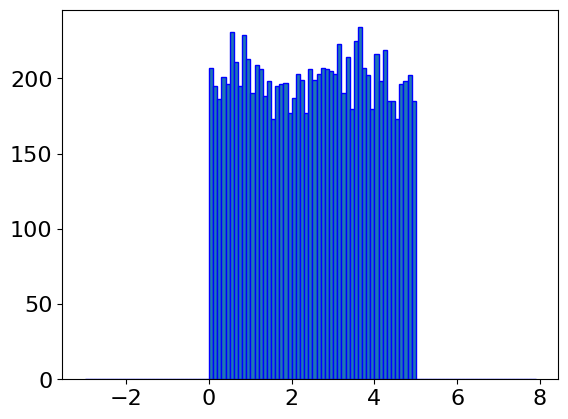

In [43]:
np.random.seed(123)

y = uniform.rvs(0, 5, 10000)
bin = np.arange(-3,8,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

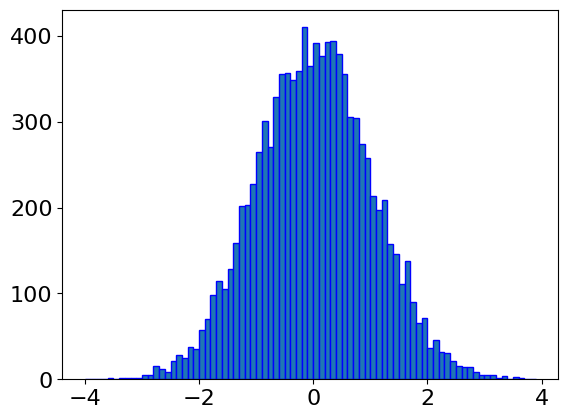

In [44]:
y = norm.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-4,4,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

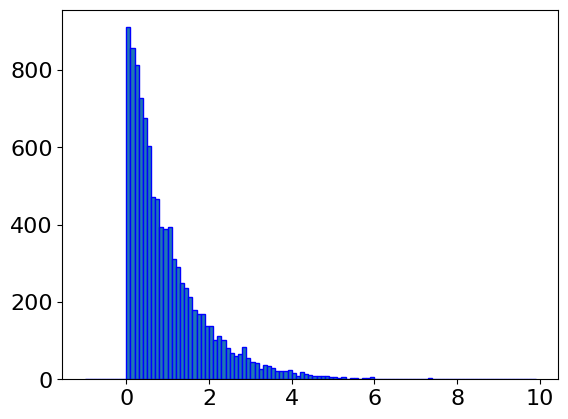

In [45]:
y = expon.rvs(0, 1, 10000)

#creating bin
bin = np.arange(-1,10,0.1)  

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

<br><br>

In [46]:
param_dist = {
    "svc__C": uniform(0.1, 1e4),  # loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-5, 1e3),
}

In [47]:
random_search = RandomizedSearchCV(
    pipe_svm, param_dist, n_iter=100, verbose=1, n_jobs=-1, random_state=123
)

In [48]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14a253550>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1486dd420>},
                   random_state=123, verbose=1)

In [49]:
random_search.best_score_

0.7383804780493433

In [50]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,9,...,82,82,82,82,82,96,96,96,96,96
mean_test_score,0.73838,0.7359,0.735277,0.733415,0.731556,0.729716,0.729068,0.728454,0.72845,0.72845,...,0.508371,0.508371,0.508371,0.508371,0.508371,0.50713,0.50713,0.50713,0.50713,0.50713
param_svc__gamma,0.00271,0.001946,0.00283,0.003148,0.003834,0.015524,0.00067,0.005593,0.00089,0.000458,...,33.017913,51.754341,126.722678,84.511472,120.952433,766.440217,739.685456,918.053216,263.398099,806.79529
param_svc__C,3427.738338,6964.791856,2865.466167,4258.402903,7224.533826,1511.374523,3617.986556,2408.658977,7636.928414,9053.515757,...,5826.810879,7087.073954,6648.824488,6007.085678,957.225166,4830.442643,9019.213727,7049.688305,3370.763834,26.980646
mean_fit_time,0.270511,0.390626,0.250277,0.362036,0.60281,0.421078,0.120652,0.334508,0.233567,0.171383,...,0.081538,0.080531,0.059941,0.06476,0.059756,0.058091,0.055657,0.057711,0.064806,0.059273


- This is a bit fancy. What's nice is that you can have it concentrate more on certain values by setting the distribution. 


### Advantages of `RandomizedSearchCV`

- Faster compared to `GridSearchCV`.
- Adding parameters that do not influence the performance does not affect efficiency.
- Works better when some parameters are more important than others. 
- In general, I recommend using `RandomizedSearchCV` rather than `GridSearchCV`.    

### Advantages of `RandomizedSearchCV`

![](img/randomsearch_bergstra.png)
    
Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

- The yellow on the left shows how your scores are going to change when you vary the unimportant hyperparameter.
- The green on the top shows how your scores are  going to change when you vary the important hyperparameter.
- You don't know in advance which hyperparameters are important for your problem.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

### Searching for optimal parameters with successive halving¶

- Successive halving is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources (e.g., small amount of training data) at the first iteration.
- Checkout [successive halving with grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).

## (Optional) Fancier methods 
- Both `GridSearchCV` and `RandomizedSearchCV` do each trial independently.
- What if you could learn from your experience, e.g. learn that `max_depth=3` is bad?
  - That could save time because you wouldn't try combinations involving `max_depth=3` in the future.
- We can do this with `scikit-optimize`, which is a completely different package from `scikit-learn`
- It uses a technique called "model-based optimization" and we'll specifically use "Bayesian optimization".
  - In short, it uses machine learning to predict what hyperparameters will be good.
  - Machine learning on machine learning!

- This is an active research area and there are sophisticated packages for this.

Here are some examples 
- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)
- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)

## ❓❓ Questions for you

### (iClicker) Exercise 8.1 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

- (A) If you get best results at the edges of your parameter grid, it might be a good idea to adjust the range of values in your parameter grid.   
- (B) Grid search is guaranteed to find best hyperparameters values. 
- (C) It is possible to get different hyperparameters in different runs of `RandomizedSearchCV`.

### Questions for class discussion (hyperparameter optimization)

- Suppose you have 10 hyperparameters, each with 4 possible values. If you run `GridSearchCV` with this parameter grid, how many cross-validation experiments will be carried out? 
- Suppose you have 10 hyperparameters and each takes 4 values. If you run `RandomizedSearchCV` with this parameter grid with `n_iter=20`, how many cross-validation experiments will be carried out? 

<br><br><br><br>

## Optimization bias/Overfitting of the validation set

### Overfitting of the validation error 

- Why do we need to evaluate the model on the test set in the end?
- Why not just use cross-validation on the whole dataset? 
- While carrying out hyperparameter optimization, we usually try over many possibilities.  
- If our dataset is small and if your validation set is hit too many times, we suffer from **optimization bias** or **overfitting the validation set**. 

### Optimization bias of parameter learning
- Overfitting of the training error
- An example: 
    - During training, we could search over tons of different decision trees.
    - So we can get "lucky" and find a tree with low training error by chance.

    

### Optimization bias of hyper-parameter learning

- Overfitting of the validation error
- An example: 
    - Here, we might optimize the validation error over 1000 values of `max_depth`.
    - One of the 1000 trees might have low validation error by chance.

### (Optional) Example 1: Optimization bias

Consider a multiple-choice (a,b,c,d) "test" with 10 questions:
- If you choose answers randomly, expected grade is 25% (no bias).
- If you fill out two tests randomly and pick the best, expected grade is 33%.
    - Optimization bias of ~8%.
- If you take the best among 10 random tests, expected grade is ~47%.
- If you take the best among 100, expected grade is ~62%.
- If you take the best among 1000, expected grade is ~73%.
- If you take the best among 10000, expected grade is ~82%.
    - You have so many "chances" that you expect to do well.
    
**But on new questions the "random choice" accuracy is still 25%.**

In [51]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(10.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 10.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.33
The expected grade among the best of 10 tests is : 0.47
The expected grade among the best of 100 tests is : 0.62
The expected grade among the best of 1000 tests is : 0.73
The expected grade among the best of 10000 tests is : 0.83


### (Optional) Example 2: Optimization bias 

- If we instead used a 100-question test then:
    - Expected grade from best over 1 randomly-filled test is 25%.
    - Expected grade from best over 2 randomly-filled test is ~27%.
    - Expected grade from best over 10 randomly-filled test is ~32%.
    - Expected grade from best over 100 randomly-filled test is ~36%.
    - Expected grade from best over 1000 randomly-filled test is ~40%.
    - Expected grade from best over 10000 randomly-filled test is ~43%.

- The optimization bias **grows with the number of things we try**.
    - “Complexity” of the set of models we search over.
- But, optimization bias **shrinks quickly with the number of examples**.
    - But it’s still non-zero and growing if you over-use your validation set!    

In [52]:
# (Optional) Code attribution: Rodolfo Lourenzutti
number_tests = [1, 2, 10, 100, 1000, 10000]
for ntests in number_tests:
    y = np.zeros(10000)
    for i in range(10000):
        y[i] = np.max(np.random.binomial(100.0, 0.25, ntests))
    print(
        "The expected grade among the best of %d tests is : %0.2f"
        % (ntests, np.mean(y) / 100.0)
    )

The expected grade among the best of 1 tests is : 0.25
The expected grade among the best of 2 tests is : 0.27
The expected grade among the best of 10 tests is : 0.32
The expected grade among the best of 100 tests is : 0.36
The expected grade among the best of 1000 tests is : 0.40
The expected grade among the best of 10000 tests is : 0.43


### Optimization bias on the Spotify dataset

In [53]:
X_train_tiny, X_test_big, y_train_tiny, y_test_big = train_test_split(
    X_spotify, y_spotify, test_size=0.99, random_state=42
)

In [54]:
X_train_tiny.shape

(20, 13)

In [55]:
X_train_tiny.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
130,0.055100,0.547,251093,0.643,0.000000,1,0.2670,-8.904,1,0.2270,143.064,4.0,0.1870
1687,0.000353,0.420,210240,0.929,0.000747,7,0.1220,-3.899,0,0.1210,127.204,4.0,0.3180
871,0.314000,0.430,193427,0.734,0.000286,9,0.0808,-10.043,0,0.1020,133.992,4.0,0.0537
1123,0.082100,0.725,246653,0.711,0.000000,10,0.0931,-4.544,1,0.0335,93.003,4.0,0.4760
1396,0.286000,0.616,236960,0.387,0.000000,9,0.2770,-6.079,0,0.0335,81.856,4.0,0.4700


In [56]:
pipe = make_pipeline(StandardScaler(), SVC())

In [57]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "svc__gamma": 10.0 ** np.arange(-20, 10),
    "svc__C": 10.0 ** np.arange(-20, 10),
}
print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 900


{'svc__gamma': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]),
 'svc__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
        1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
        1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
        1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])}

In [58]:
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_grid, n_jobs=-1, n_iter=900, cv=5, random_state=123
)
random_search.fit(X_train_tiny, y_train_tiny);

In [59]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svc__gamma",
        "param_svc__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,3,3,3,3,3,3,3,3,...,20,20,20,20,20,20,20,20,20,900
mean_test_score,0.8,0.8,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,...,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.55
param_svc__gamma,0.0,0.0,0.001,0.001,0.001,0.0,0.001,0.001,0.001,0.001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,1000000000.0,0.0
param_svc__C,1000000000.0,100000000.0,1000000000.0,10000.0,1000000.0,10000000.0,100000.0,1000.0,10000000.0,100000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000000000.0,1000000000.0
mean_fit_time,0.000974,0.001891,0.003131,0.000929,0.001277,0.001868,0.000991,0.001699,0.000961,0.001782,...,0.00129,0.003133,0.000963,0.000936,0.00098,0.000961,0.002592,0.000955,0.001115,0.00093


Given the results: one might claim that we found a model that performs with 0.8 accuracy on our dataset. 

- Do we really believe that 0.80 is a good estimate of our test data?
- Do we really believe that `gamma`=0.0 and C=1_000_000_000 are the best hyperparameters? 

- Let's find out the test score with this best model. 

In [60]:
random_search.score(X_test, y_test)

0.6163366336633663

- The results above are overly optimistic. 
    - because our training data is very small and so our validation splits in cross validation would be small. 
    - because of the small dataset and the fact that we hit the small validation set 900 times and it's possible that we got lucky on the validation set! 

- As we suspected, the best cross-validation score is not a good estimate of our test data; it is overly optimistic. 
- We can trust this test score because the test set is of good size.

In [61]:
X_test_big.shape

(1997, 13)

### Overfitting of the validation data

The following plot demonstrates what happens during overfitting of the validation data.  
![](img/optimization-bias.png)
<!-- <center>
<img src='./img/optimization-bias.png' width="600">
</center>
 -->

[Source](https://amueller.github.io/COMS4995-s20/slides/aml-03-supervised-learning/#20)

- Thus, not only can we not trust the cv scores, we also cannot trust cv's ability to choose of the best hyperparameters. 


### Why do we need a test set? 
- This is why we need a test set.
- The frustrating part is that if our dataset is small then our test set is also small 😔. 
- But we don't have a lot of better alternatives, unfortunately, if we have a small dataset. 

### When test score is much lower than CV score
- What to do if your test score is much lower than your cross-validation score:
    - Try simpler models and use the test set a couple of times; it's not the end of the world.
    - Communicate this clearly when you report the results. 

### Large datasets solve many of these problems
- With infinite amounts of training data, overfitting would not be a problem and you could have your test score = your train score.
    - Overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
    - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better and robust. 

## ❓❓ Questions for you

Attribution: From Mark Schmidt's notes

### Would you trust the model?  

- You have a dataset and you give me half of it. I build a model using all the data you have given me and I tell you that the model accuracy is 0.99. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

### Would you trust the model?  

- You have a dataset and you give me half of it. I build a model using 80% of the data given to me and report the accuracy of 0.95 on the remaining 20% of the data. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

### Would you trust the model?  

- You have a dataset and you give me 1/10th of it. The dataset given to me is rather small and so I split it into 96% train and 4% validation split. I carry out hyperparameter optimization using a single 4% validation split and report validation accuracy of 0.97. Would it classify the rest of the data with similar accuracy? 

1. Probably 
2. Probably not 

## Final comments and summary

#### Automated hyperparameter optimization

- Advantages 
    - reduce human effort
    - less prone to error and improve reproducibility
    - data-driven approaches may be effective
- Disadvantages
    - may be hard to incorporate intuition
    - be careful about overfitting on the validation set

Often, especially on typical datasets, we get back `scikit-learn`'s default hyperparameter values. This means that the defaults are well chosen by `scikit-learn` developers!

- The problem of finding the best values for the important hyperparameters is tricky because 
    - You may have a lot of them (e.g. deep learning). 
    - You may have multiple hyperparameters which may interact with each other in unexpected ways.    
- The best settings depend on the specific data/problem.

## Optional readings and resources

- [Preventing "overfitting" of cross-validation data](http://www.robotics.stanford.edu/~ang/papers/cv-final.pdf) by Andrew Ng